In [1]:
import numpy as np
import pandas as pd
import healpy as hp
%config InlineBackend.figure_format = 'retina'
from DS_Planck_Unet import west_val, east_val
from matplotlib import pyplot as plt
from DS_Planck_Unet import load_planck_model, draw_pic_with_mask, draw_pic, val_pix
from DS_healpix_fragmentation import *
from DS_data_transformation import pic2fits, normalize
from DS_detector import *
import os
from astropy.coordinates import SkyCoord
from astropy import units as u
from tqdm.notebook import tqdm
from DS_data_transformation import normalize
import seaborn as sns
from scipy.special import logit
from DS_models_stat import stat_orig_cats, do_all_stats
from DS_detector import rematch_cat
from matplotlib import cm
from matplotlib.ticker import LinearLocator
from DS_healpix_fragmentation import cut_cat_by_pix

In [53]:
max_pred_unite = np.arange(0.1, 1, 0.05)

In [59]:
def this_ax(ax, ylim=[0, 1.05], yticks=[0.1, 1, 0.1]):
    l = ax.axvline(0.65, c='brown', linestyle='-.')
    l.set_label('max_pred=0.65')
    ax.set_xlabel('max_pred')
    ax.set_xticks(np.arange(0.1, 1, 0.1), minor=True)
    ax.set_xlim(0.1, 1)
    ax.set_ylim(*ylim)
    ax.set_yticks(np.arange(*yticks), minor=True)
    ax.set_yticks(np.arange(*yticks)[::2], minor=False)
    ax.grid(True, axis='both', which='major', linestyle=':')
    ax.grid(True, axis='both', which='minor', alpha=0.2, linestyle=':')
    ax.legend()

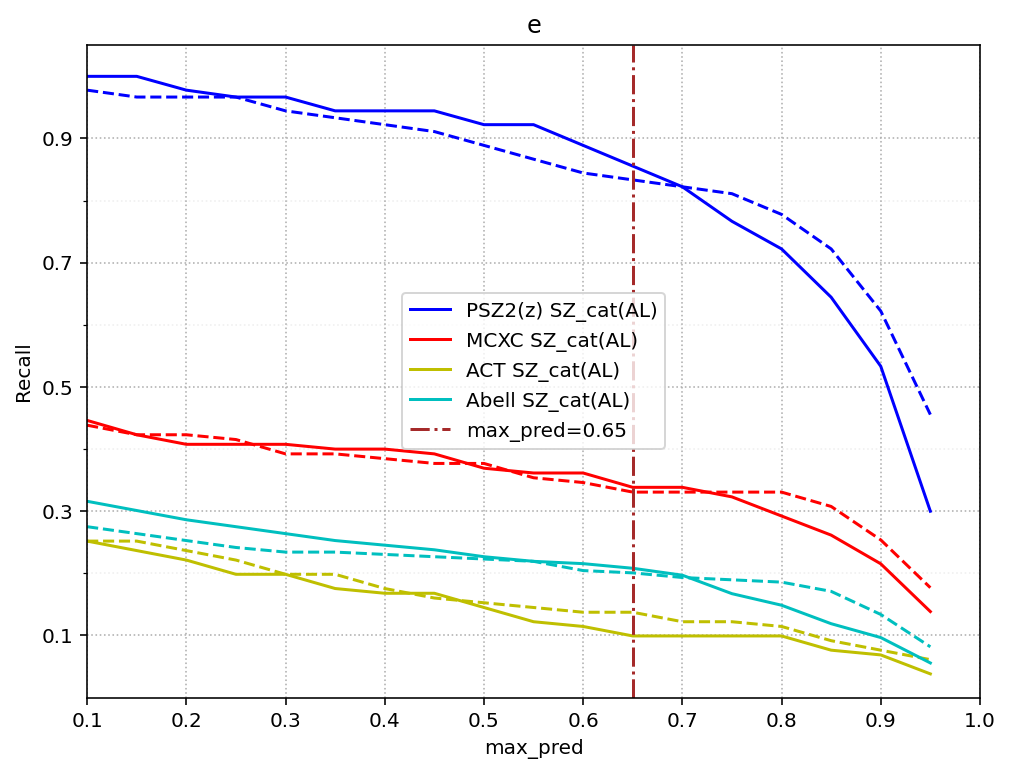

In [60]:
pixname = 'e'
show_basic = True 
selected = ['PSZ2(z)', 'MCXC', 'ACT', 'Abell']
base_cat_name = 'SZ_cat(basic)'
al_cat_name = 'SZ_cat(AL)'
recalls = {al_cat_name : pd.read_csv('./check/all_found34_recall_max_pred_pix{}.csv'.format(pixname), index_col='max_pred'),
     base_cat_name : pd.read_csv('./check/pz_rot28_recall_max_pred_pix{}.csv'.format(pixname), index_col='max_pred')
}

_, ax = plt.subplots(1, 1, figsize=(8, 6))
for c, name in zip('brycg', selected):
    for name_cat, st in zip(recalls, ['-', '--']):
        if not show_basic and name_cat == base_cat_name:
            continue
        df = recalls[name_cat]
        s, = ax.plot(df.index, df[name], c=c, linestyle=st)
        if name_cat == al_cat_name:
            s.set_label(name + ' ' + name_cat)
ax.set_ylabel('Recall')
ax.set_title(pixname)
this_ax(ax)
plt.show()

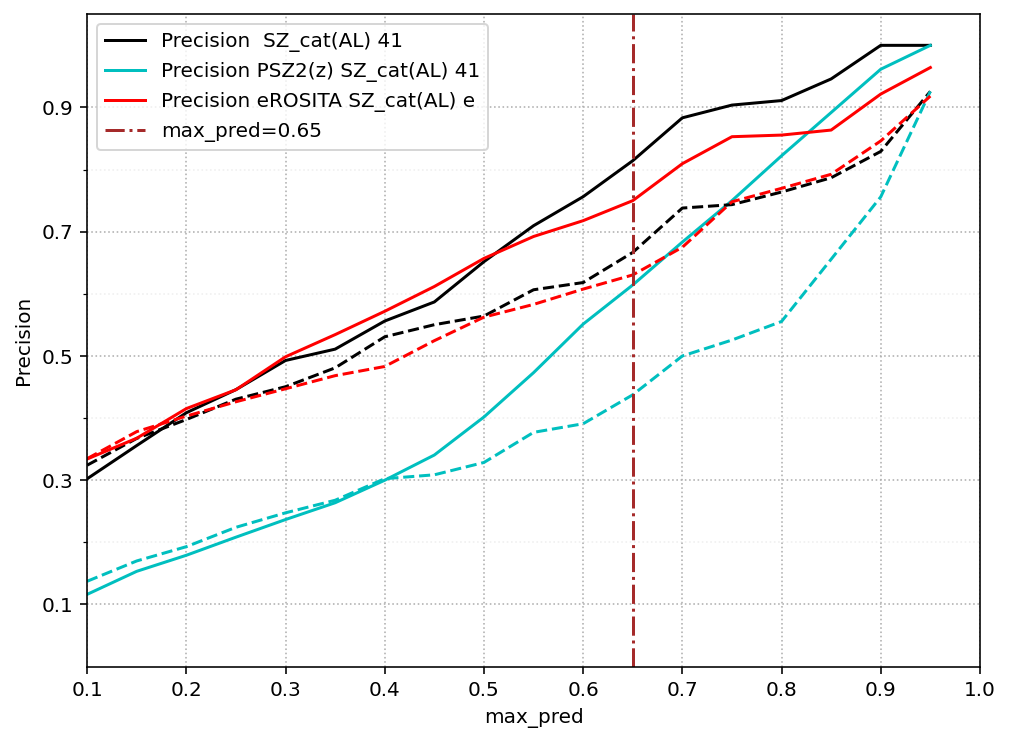

In [61]:
def plot_precision(ax, pixname, show_basic, selected, colors='kcr'):
    base_cat_name = 'SZ_cat(basic)'
    al_cat_name = 'SZ_cat(AL)'
    recalls = {al_cat_name : pd.read_csv('./check/all_found34_recall_max_pred_pix{}.csv'.format(pixname), index_col='max_pred'),
         base_cat_name : pd.read_csv('./check/pz_rot28_recall_max_pred_pix{}.csv'.format(pixname), index_col='max_pred')
    }
    for name_cat, st in zip(recalls, ['-', '--']):
        df = recalls[name_cat]
        for prec, c in zip(selected, colors):
            prm = 'precision' if prec == '' else 'precision_' + prec
            s, = ax.plot(df.index, df[prm], c=c, linestyle=st)
            if name_cat == al_cat_name:
                s.set_label('Precision '+ prec + ' ' + name_cat + ' ' + pixname)

show_basic = True 

_, ax = plt.subplots(1, 1, figsize=(8, 6))
plot_precision(ax, pixname='41', show_basic=show_basic, selected=['', 'PSZ2(z)'])            
plot_precision(ax, pixname='e', show_basic=show_basic, selected=['eROSITA'], colors='r')
            
ax.set_ylabel('Precision')
this_ax(ax)
plt.show()

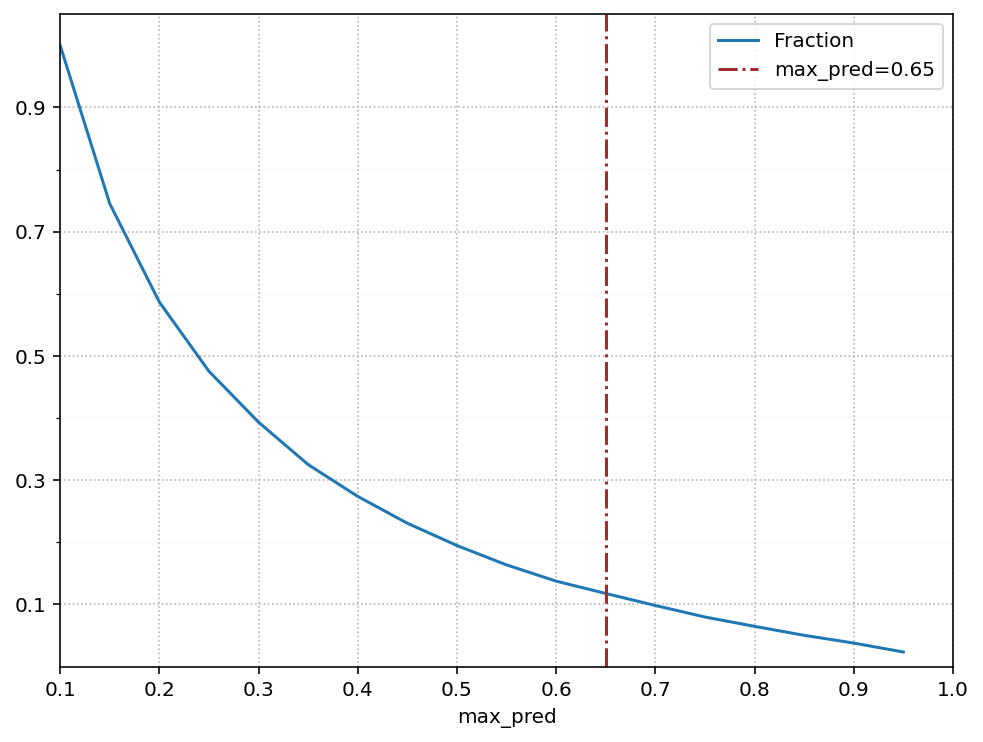

In [62]:
#fraction
df = pd.read_csv('/home/rt2122/Data/detected_cats/full_pz_all_found34_thr0.1_step8_no_fn.csv')
fraction = []
for val in max_pred_unite:
    fraction.append(np.count_nonzero(df['max_pred'] >= val) / len(df))

_, ax = plt.subplots(1, 1, figsize=(8, 6))
l, = ax.plot(max_preds, fraction)
l.set_label('Fraction')
this_ax(ax)

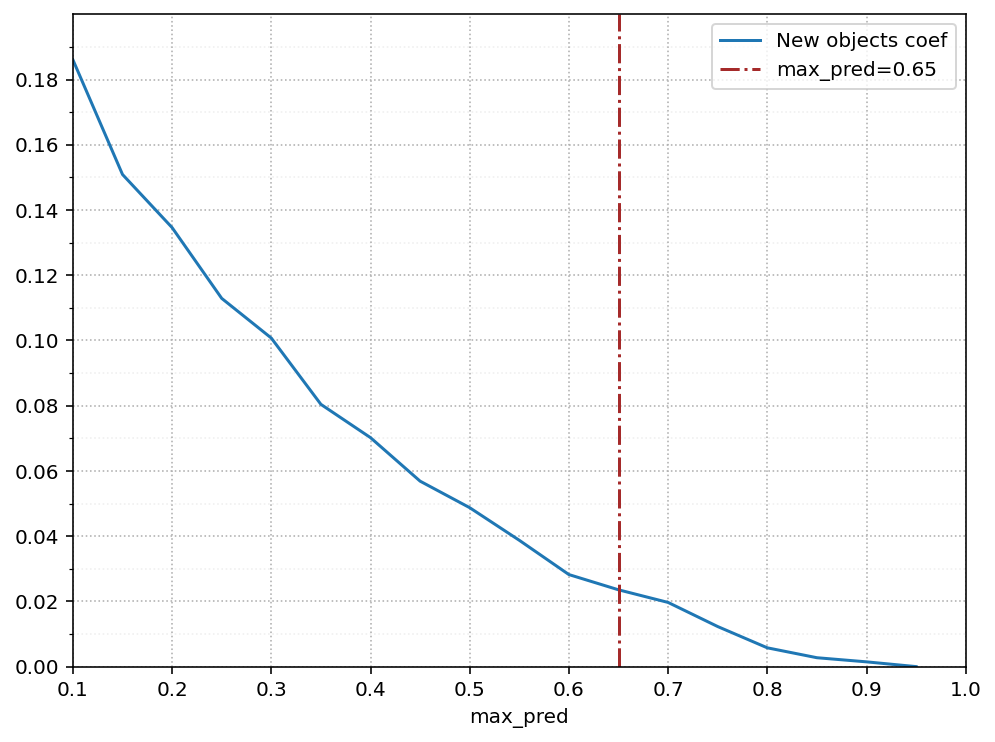

In [64]:
def get_precision_dif(pixname, cat='PSZ2(z)'):
    recall = pd.read_csv('./check/all_found34_recall_max_pred_pix{}.csv'.format(pixname), index_col='max_pred')
    return recall['precision'] - recall['precision_'+cat]

_, ax = plt.subplots(1, 1, figsize=(8, 6))
precision_dif = get_precision_dif(pixname='41')
l, = ax.plot(max_pred_unite, precision_dif * fraction)
l.set_label('New objects coef')
this_ax(ax, ylim=[0, 0.2], yticks=[0, 0.2, 0.01])

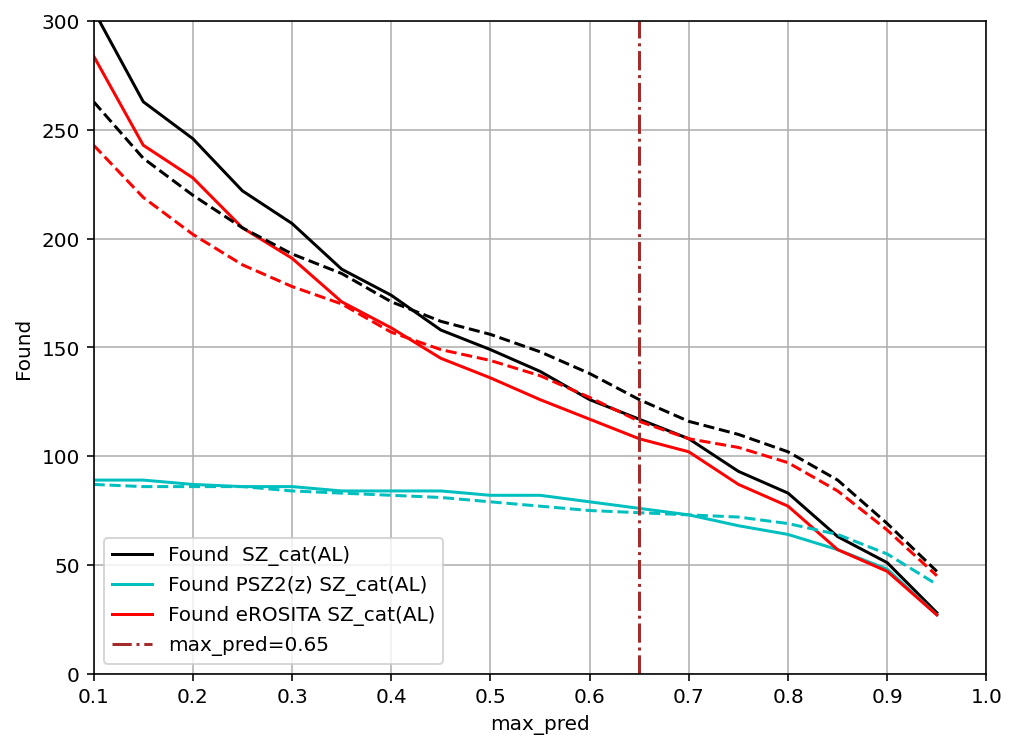

In [40]:
def plot_found(ax, pixname, show_basic, selected, colors='kcr'):
    base_cat_name = 'SZ_cat(basic)'
    al_cat_name = 'SZ_cat(AL)'
    recalls = {al_cat_name : pd.read_csv('./check/all_found34_recall_max_pred_pix{}.csv'.format(pixname), index_col='max_pred'),
         base_cat_name : pd.read_csv('./check/pz_rot28_recall_max_pred_pix{}.csv'.format(pixname), index_col='max_pred')
    }
    for name_cat, st in zip(recalls, ['-', '--']):
        df = recalls[name_cat]
        for prec, c in zip(selected, colors):
            prm = 'found' if prec == '' else 'found_' + prec
            s, = ax.plot(df.index, df[prm], c=c, linestyle=st)
            if name_cat == al_cat_name:
                s.set_label('Found '+ prec + ' ' + name_cat)

show_basic = True 

_, ax = plt.subplots(1, 1, figsize=(8, 6))
plot_found(ax, pixname='e', show_basic=show_basic, selected=['', 'PSZ2(z)', 'eROSITA'])            
            
ax.set_ylabel('Found')
this_ax(ax, ylim=[0, 300], yticks=[0, 350, 50])
plt.show()

In [2]:
def stat_orig_cats_simple(det_cats_dict, big_pix=None, true_cats_dir='/home/rt2122/Data/original_catalogs/csv/', match_dist=5/60, read_det_files=True, 
                         excl_cats=[], spec_precision=[], other_cats={'eROSITA' :'~/Data/SRGz/clusters/clusters1_east_val_edit.csv', 
                        'PSZ2(z)' : '~/Data/clusters/planck_z.csv'}):
    import os
    from astropy.coordinates import SkyCoord
    from astropy import units as u
    import numpy as np
    import pandas as pd
    
    
    true_cats_files = next(os.walk(true_cats_dir))[-1]
    true_cats_files = [os.path.join(true_cats_dir, file) for file in true_cats_files]
    
    true_cats = {os.path.splitext(os.path.basename(file))[0] : pd.read_csv(file) for file in true_cats_files}
    true_cats.update({name : pd.read_csv(other_cats[name]) for name in other_cats})

    true_cats = {tr_cat_name : true_cats[tr_cat_name] for tr_cat_name in true_cats if not (tr_cat_name in excl_cats)}
    det_cats = det_cats_dict
    if read_det_files:
        det_cats = {name : 
                pd.read_csv(det_cats_dict[name]) for name in det_cats_dict}
    
    recall_df = []
    if not (big_pix is None):
        for tr_name in true_cats:
            true_cats[tr_name] = cut_cat_by_pix(true_cats[tr_name], big_pix)
        for name in det_cats:
            det_cats[name] = cut_cat_by_pix(det_cats[name], big_pix)
    
    for name in det_cats:
        df = det_cats[name]
        df = df[df['status'] != 'fn']
        df.index = np.arange(len(df))
        df['found'] = False
        det_cats[name] = df
        
    
    for det_name in det_cats:
        det = det_cats[det_name]
        line_r = do_all_stats(det, true_cats, match_dist=match_dist, spec_precision=spec_precision)
        recall_df.append(pd.DataFrame(line_r, index=[det_name]))
    
    recall_df = pd.concat(recall_df)
    return recall_df

In [3]:
def cut_max_pred(cat, max_pred):
    df = cat.copy()
    df = df[df['max_pred'] >= max_pred]
    df.index = np.arange(len(df))
    return df

In [4]:
cats_dict = {'pz_rot28' : '/home/rt2122/Data/detected_cats/full_pz_rot28_thr0.1_step8_no_fn.csv',
            'all_found34' : '/home/rt2122/Data/detected_cats/full_pz_all_found34_thr0.1_step8_no_fn.csv'}
big_pix = [41]
pixname = '41'
for det_name in cats_dict:
    det_cat = pd.read_csv(cats_dict[det_name])
    cat_d = {max_pred_prm : cut_max_pred(det_cat, max_pred_prm) for max_pred_prm in max_pred_unite}
    recall_df = stat_orig_cats_simple(cat_d, big_pix=big_pix, read_det_files=False, match_dist=400/3600, 
                                     spec_precision=['PSZ2(z)', 'eROSITA'])
    recall_df = recall_df.sort_index()
    recall_df.index.name='max_pred'
    recall_df.to_csv('./check/{}_recall_max_pred_pix{}.csv'.format(det_name, pixname))